In [1]:
#Impoort required librarues
import urllib.request
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import warnings
warnings.filterwarnings('ignore')# Suppress all warnings

In [2]:
#Data loading from Google drive
def load_csv_from_drive(file_id):
    url = f'https://drive.google.com/uc?id={file_id}'
    response = urllib.request.urlopen(url)
    data = response.read()
    df = pd.read_csv(io.BytesIO(data))
    return df

#Google drive Link
customers_file_id = "1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
products_file_id = "1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0"
transactions_file_id = "1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"

#Creating DataFrame
cust_df = load_csv_from_drive(customers_file_id)
prod_df = load_csv_from_drive(products_file_id)
transactions_df = load_csv_from_drive(transactions_file_id)

In [6]:
# Merge the datasets for a comprehensive customer profile
all_merged = transactions_df.merge(cust_df, on="CustomerID").merge(prod_df, on="ProductID")


# Feature Engineering for Lookalike Model


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler


customer_profile = all_merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',               # Total spending
    'Quantity': 'sum',                 # Total quantity purchased
    'ProductID': lambda x: x.nunique(),# Number of unique products purchased
    'Category': lambda x: x.nunique() # Number of unique categories purchased
}).reset_index()

# Add Region and Signup Date (optional encoding for categorical features)
customer_profile = customer_profile.merge(cust_df[['CustomerID', 'Region']], on='CustomerID')
region_dummies = pd.get_dummies(customer_profile['Region'], prefix='Region')
customer_profile = pd.concat([customer_profile, region_dummies], axis=1)
customer_profile.drop(columns=['Region'], inplace=True)


In [8]:
# Standardization the numerical features for best results
scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'ProductID', 'Category']
customer_profile[numerical_features] = scaler.fit_transform(customer_profile[numerical_features])

In [9]:
# Computation of Similarity Scores using Cosine Similarity
similarity_matrix = cosine_similarity(customer_profile.drop(columns=['CustomerID']))

In [10]:
# Lookalike Recommendations
lookalike_results = {}
for i, customer_id in enumerate(customer_profile['CustomerID']):
    similarity_scores = list(enumerate(similarity_matrix[i]))#Similarity score calcultaion
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)    # Sort by highest similarity (excluding the customer itself)
    top_similar_customers = [
        (customer_profile['CustomerID'][idx], round(score, 4))
        for idx, score in similarity_scores[1:4]  # Exclude self (index 0)
    ]
    lookalike_results[customer_id] = top_similar_customers


In [12]:
# Lookalike CSV
lookalike_df = pd.DataFrame({
    'CustomerID': lookalike_results.keys(),
    'Lookalikes': [str(val) for val in lookalike_results.values()]
})
lookalike_df.index += 1

#CSV
lookalike_df.to_csv("Lookalike.csv", index=False)
print("\nCreated 'Lookalike.csv'.")



Created 'Lookalike.csv'.


In [16]:
print("\nLookalikes for the first 20 customers:")
for idx, row in lookalike_df.head(20).iterrows():
    lookalikes = eval(row['Lookalikes'])
    customer_id = row['CustomerID']
    lookalike_info = [f"  - CustomerID: {lookalike[0]}, Similarity Score: {lookalike[1]}" for lookalike in lookalikes]
    print(f"\n {customer_id}'s Top 3 Lookalikes :")
    print("\n".join(lookalike_info))



Lookalikes for the first 20 customers:

 C0001's Top 3 Lookalikes :
  - CustomerID: C0107, Similarity Score: 0.9896
  - CustomerID: C0174, Similarity Score: 0.9717
  - CustomerID: C0011, Similarity Score: 0.9672

 C0002's Top 3 Lookalikes :
  - CustomerID: C0142, Similarity Score: 0.9906
  - CustomerID: C0159, Similarity Score: 0.9565
  - CustomerID: C0186, Similarity Score: 0.954

 C0003's Top 3 Lookalikes :
  - CustomerID: C0174, Similarity Score: 0.872
  - CustomerID: C0031, Similarity Score: 0.8466
  - CustomerID: C0001, Similarity Score: 0.8263

 C0004's Top 3 Lookalikes :
  - CustomerID: C0099, Similarity Score: 0.9591
  - CustomerID: C0087, Similarity Score: 0.9498
  - CustomerID: C0155, Similarity Score: 0.94

 C0005's Top 3 Lookalikes :
  - CustomerID: C0186, Similarity Score: 0.9978
  - CustomerID: C0159, Similarity Score: 0.9974
  - CustomerID: C0007, Similarity Score: 0.9885

 C0006's Top 3 Lookalikes :
  - CustomerID: C0187, Similarity Score: 0.8985
  - CustomerID: C0158,

# Correlation Matrix and Heatmap

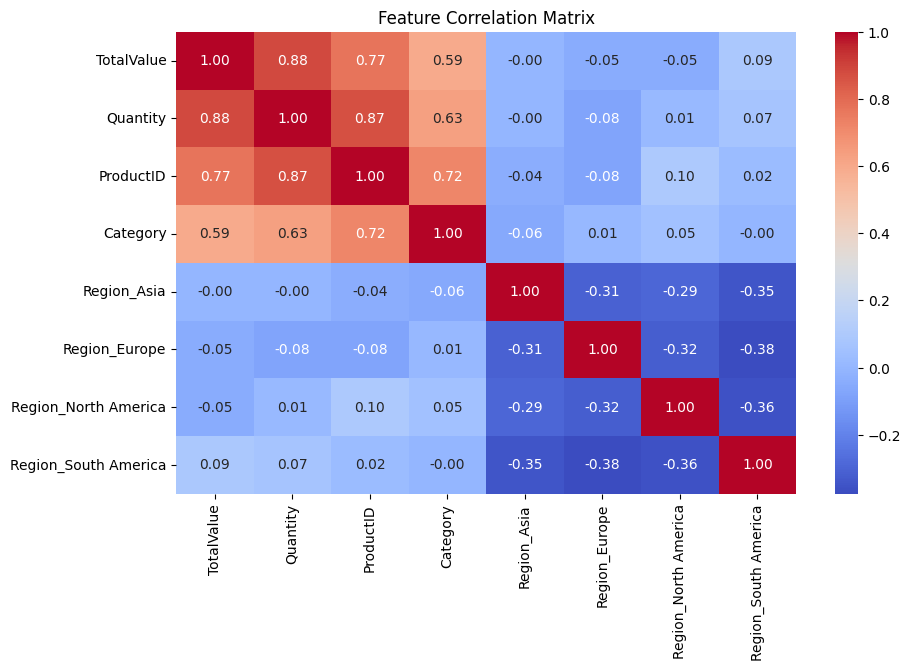

In [ ]:
# Correlation of Features
correlation_matrix = customer_profile.drop(columns=['CustomerID']).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()